# Support vector classification

Support vector classification is a supervised learning algorithm that can be used as an alternative to logistic classification. This algorithm represents the training data as points in space which are mapped so that they are divided by a gap. The new data is then mapped into the space and predicte to belong to a category based on the side of the gap they fit into.

Since we are working with a large dataset with over 9k features, it will be of interest to attempt to reduce the number of features. This can be done with a regularization parameter. One such regularization method is Lasso, which adds an $L_1$ penalty to the loss function. Using Lasso will force the weak features to have zero as a coefficient, which leads to sparse solutions. This property can be a disadvantage, since features which are considered weak may be of importance to the application. Lasso can especially be a disadvantage when we are in the case of high-dimensional data with a small sample size, which is often the case with genomic data. One possible solution to this problem is to combine the penalty from Lasso with the penalty from Ridge regression. This regularization methos is called Elastic-net, combining the $L_1$ and the $L_2$ penalty. 

The following code will create a support vector classifier with the two following regularization methods:
1. Lasso ($L_1$ penalty)
2. Elastic-net ($L_1$ and $L_2$ penalty)

## Framework to train and test the model 

We will first create a general framework to train and test a classifier. This will occur in the same way regardless of what classification and regularization method we use. The framework will include reading the training and test data, training the model and validating the accuracy of the model. 

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [2]:
# Set random state
SEED = 0

In [3]:
def read_data(filename, scaling=True, survival=False, gene=False):

    """ Function that reads file containing patient-info and gene expression,
    and separates the data into data (X) and target (y). Option to get 
    additional information (survival data, gene-info). """

    # Read data
    data = pd.read_csv(filename, sep="\t", index_col=0, encoding="utf-8")

    # Save label information
    patients = data.index
    genes = data.columns[2:-3]
    
    # Survival data
    time = data["time"]
    event = data["event"]
    
    # Extract data and target for modeling
    data = data.dropna()
    X = data.loc[:,data.columns[2:-3]].values
    y = data["cluster2_2"].values

    # Option to scale data when needed
    if scaling == True:
        scaler = StandardScaler()
        
        # Scale genes
        X = scaler.fit_transform(XX) 

    # Option to get survival data
    if survival == True:
        return X, y, patients, time, event

    # Option to get gene-list
    if gene == True:
        return X, y, genes
    
    # Option to get all information
    if gene == True and survival == True:
        return X, y, patients, time, event, genes

    return X, y

In [4]:
# Read training and test data
X_train, y_train = read_data("data/training/merged_training_data.txt")
X_test, y_test, patients, T, E = read_data("data/test/merged_test_data.txt", survival=True)

In [5]:
def train_test_model(clf):
    """Function that trains and tests a classifier. """
    
    # Train model
    model = clf.fit(X_train, y_train)
    
    # Predict on training data
    y_pred = clf.predict(X_train)
    
    # Compute accuracy of model on training data
    acc_score_train = accuracy_score(y_train, y_pred)
    
    # Predict on test data
    y_pred = clf.predict(X_test)
    
    # Compute accuracy of model on test data
    acc_score_test = accuracy_score(y_test, y_pred)
    
    # Get number of non-zero coefficients in the fitted model
    n_nonzero = 0
    for i in range(0,clf.coef_.shape[0]):
        for j in range(0,clf.coef_.shape[1]):
            if clf.coef_[i][j] != 0:
                n_nonzero += 1
    
    return model, acc_score_train, acc_score_test, n_nonzero

### 1. Lasso regularization

In [6]:
# Parameters
lamb = 0.01 
max_iter = 1000

In [7]:
# Create support vector classifier with Lasso penalty 
clf_lasso = SGDClassifier(loss="hinge", penalty="l1", alpha=lamb, max_iter=max_iter, n_jobs=8, random_state=SEED)

In [8]:
# Train and test classifier
lasso_model, acc_score_train, acc_score_test, n_nonzero = train_test_model(clf_lasso)
print("Accuracy score on training data: ", acc_score_train)
print("Accuracy score on test data: ",  acc_score_test)
print("Number of non-zero features: ", n_nonzero)

Accuracy score on training data:  0.8769541099344428
Accuracy score on test data:  0.6931818181818182
Number of non-zero features:  1449


### 2. Elastic-net regularization

In [9]:
# Create support vector classifier with Lasso penalty 
clf_elastic = SGDClassifier(loss="hinge", penalty="elasticnet", alpha=lamb, max_iter=max_iter, n_jobs=8, random_state=SEED)

In [10]:
# Train and test classifier
elastic_model, acc_score_train, acc_score_test, n_nonzero = train_test_model(clf_elastic)
print("Accuracy score on training data: ", acc_score_train)
print("Accuracy score on test data: ",  acc_score_test)
print("Number of non-zero features: ", n_nonzero)

Accuracy score on training data:  0.9947049924357034
Accuracy score on test data:  0.6827651515151515
Number of non-zero features:  3624


## Survival analysis
To compute the survival function we use the Kaplan-Meier estimator. The Kaplan-Meier estimator can measure the fraction of patients living after treatment. In this particular case, it will estimate the probability that a patient is alive after having the tumor surgically removed. 

In [13]:
def kaplan_meier(df, ax, label):
    """ Function that estimates survival using the Kaplan-Meier estimator, given dataframe with 
    survival data. """

    # Get event and time from df
    E = df["event"] # dead = 1
    T = df["time"]
    T = T/365. # time in years
    T = T.apply(lambda x: 15. if x >= 15. else x) # set time limit to 15 years

    # Compute surival estimates for all donor samples
    kmf = KaplanMeierFitter()
    kmf.fit(T, E, label=label)
    kmf.plot(ax=ax)

    return T, E, kmf.survival_function_

In [14]:
def estimate_based_on_clustering(df, ax):
    """ Function that estimates survival for each cluster in a dataframe. """
    
    # Cluster names and counts
    clusters = df.cluster2_pred.unique()
    cluster_counts = df.cluster2_pred.value_counts()
    
    # Estimate survival for each predicted cluster
    C1 = df.loc[df["cluster2_pred"] == 1]
    T1, E1, c1_surv_func = kaplan_meier(C1, ax, label="Cluster B (n=%d)" %cluster_counts[1])
    C2 = df.loc[df["cluster2_pred"] == 0]
    T2, E2, c2_surv_func = kaplan_meier(C2, ax, label="Not cluster B (n=%d)" %cluster_counts[0])

    # Logrank test
    res = logrank_test(T1, T2, E1, E2)

    return c1_surv_func, c2_surv_func, res.p_value

In [15]:
# Get survival data and the predicted cluster for test data
d_lasso = {"samplename": patients, "time": T, "event": E, "cluster2_pred": clf_lasso.predict(X_test)}
pred_data_lasso = pd.DataFrame(d_lasso).dropna()
d_elastic = {"samplename": patients, "time": T, "event": E, "cluster2_pred": clf_elastic.predict(X_test)}
pred_data_elastic = pd.DataFrame(d_elastic).dropna()

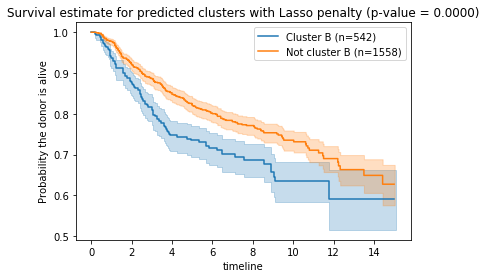

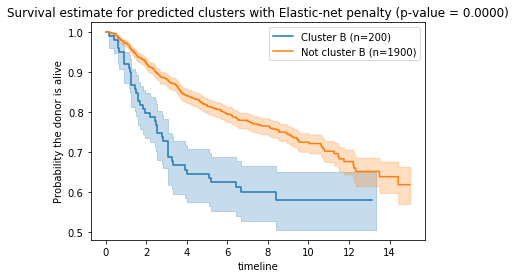

Lasso: p-value =  2.4553527045077727e-05
Elastic-net: p-value =  9.4151200968937e-08


In [16]:
# Plot survival curves for prediction on test data
ax = plt.subplot(111)
f1_l, f2_l, p_l = estimate_based_on_clustering(pred_data_lasso, ax)
plt.ylabel("Probability the donor is alive")
plt.title("Survival estimate for predicted clusters with Lasso penalty (p-value = %.4f)" %p_l)
plt.show()
ax = plt.subplot(111)
f1_el, f2_el, p_el = estimate_based_on_clustering(pred_data_elastic, ax)
plt.ylabel("Probability the donor is alive")
plt.title("Survival estimate for predicted clusters with Elastic-net penalty (p-value = %.4f)" %p_el)
plt.show()
print("Lasso: p-value = ", p_l)
print("Elastic-net: p-value = ", p_el)